This notebook builds on the `3_Neural Style Transfer - Loss Experiments.ipynb` notebook by experimenting with different layer choices.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# Getting the Images

In [ ]:
# *****************************************************************************
# To get this code to work on your system, you may need to re-write this cell,
# depending on where you plan to run these files from. As you can see, I chose
# to put the files on my Google Drive and run them from there using Google
# Colab. You may choose another approach, such as running files locally.
# *****************************************************************************
from google.colab import drive
drive.mount('/content/drive')

base_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/Hinton.jpg"
style_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/GeorgeFloyd.jpg"

In [ ]:
# Make sure the images are a similar size. Widely differing sizes can make the
# style transfer more difficult.
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

Mounted at /content/drive


In [ ]:
# Opens, reizes, and converys an image into a numpy array.
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Transform the the array (for use with VGG19 ImageNet).
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# Converts a numpy array back into an image.
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # Zero-center the values by removing the mean pixel value from ImageNet.
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Convert the images from BGR to RGB.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
base_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)

# Setting up the Network

In [ ]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Let's display information about the model to remind ourselves of the layers that are available.

In [ ]:
print(model.summary())

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

None


# Choosing the Content and Style Layers

For the content layer options:
- A single layer is used to measure the content loss.
- One of the higher convolutional layers is typically chosen.
- For their paper, Gatys et al chose the conv4_2 layer.
- In his book, Chollet chose the block5_conv2 layer.
- Let's try each block in the highest convolutional layer.

For the style layer options:
- We combine the feature correlations of multiple layers.
- For their paper, Gatys et al chose the conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1 layers.
- In his book, Chollet chose the block1_conv1, block2_conv1, block3_conv1, block4_conv1, and block5_conv1 layers.
- Like Gatys and Chollet, let's try choosing the same block in each convolutional layer.
- This means there are two options available to us.

In [ ]:
content_layer_options = ["block5_conv1", "block5_conv2", "block5_conv3", "block5_conv4"]

style_layer_options = [
    ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"],
    ["block1_conv2", "block2_conv2", "block3_conv2", "block4_conv2", "block5_conv2"],
]

# Setting up the Loss Functions

In [ ]:
content_weight = 2.5e-8
style_weight = 1e-2
total_variation_weight = 1e-2

def content_loss(base_img, generated_img):
    # Compute the mean squared error between the two images.
    return tf.reduce_sum(tf.square(generated_img - base_img))

def gram_matrix(x):
    # Compute the Gram matrix.
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, generated_img):
    # Compute the Gram matrices of the style and combination images.
    S = gram_matrix(style_img)
    C = gram_matrix(generated_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    # Compute the total variation loss, which operates on the generated image.
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(generated_image, base_image, style_image, content_layer_name, style_layer_names):
    input_tensor = tf.concat([base_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss to zero.
    loss = tf.zeros(shape=())

    # Add the content loss.
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    generated_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, generated_features)

    # Add the style loss.
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_features, generated_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    # Add the total variation loss.
    loss += total_variation_weight * total_variation_loss(generated_image)
    return loss

# Performing Gradient Descent

array([[[ 98, 194, 128],
        [101, 201, 135],
        [ 99, 201, 139],
        ...,
        [ 90, 214, 163],
        [ 95, 208, 154],
        [107, 205, 149]],

       [[ 93, 190, 127],
        [ 97, 200, 136],
        [ 95, 202, 141],
        ...,
        [ 90, 207, 160],
        [ 95, 200, 150],
        [ 97, 193, 141]],

       [[ 89, 187, 128],
        [ 92, 197, 138],
        [ 91, 202, 146],
        ...,
        [ 83, 205, 163],
        [ 92, 199, 153],
        [ 95, 192, 148]],

       ...,

       [[  0,  97, 133],
        [  1,  98, 137],
        [  0,  96, 139],
        ...,
        [  0,  63, 129],
        [  0,  36, 110],
        [  0,  15,  93]],

       [[  3, 100, 127],
        [  7, 102, 133],
        [  4, 101, 135],
        ...,
        [  0,  69, 136],
        [  0,  47, 120],
        [  0,  31, 105]],

       [[  0,  95, 116],
        [  5,  97, 127],
        [  0,  93, 123],
        ...,
        [  0,  70, 136],
        [  0,  50, 124],
        [  0,   0,   0]]], dtype=uint8)
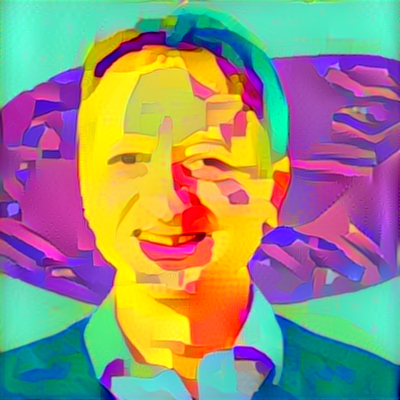

Train step: 4000
Image saved to /content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/content_block5_conv4_style_4.png


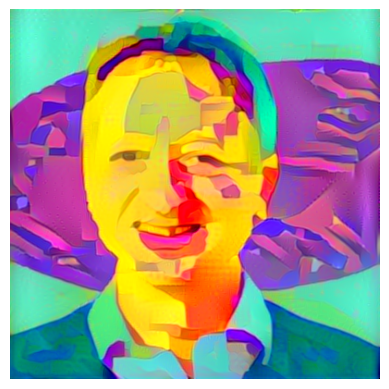

In [ ]:
@tf.function
def compute_loss_and_grads(generated_image, base_image, style_image, content_layer_name, style_layer_names):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, base_image, style_image, content_layer_name, style_layer_names)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

iterations = 4000

for cl in content_layer_options:
    # If I include all layer details in the generated image filename, it will
    # be impossible to work with. Instead, I will simply use a counter to
    # distinguish the file names, and then cross reference back to the code to
    # determine which counter corresponds to which settings.
    counter = 0
    for sl in style_layer_options:
        counter += 1
        # Reset generated image before each experiment
        generated_image = tf.Variable(preprocess_image(base_image_path))

        # Create a new optimizer for each set of weights
        optimizer = keras.optimizers.RMSprop(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
            ),
            rho=0.9,
            epsilon=1e-7
        )

        for i in range(1, iterations + 1):
            loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, cl, sl)
            optimizer.apply_gradients([(grads, generated_image)])
            print(".", end='', flush=True)
            if i % 100 == 0:
                print(f"Iteration {i}: loss={loss:.2f}")
                img = deprocess_image(generated_image.numpy())
                display.clear_output(wait=True)
                display.display(img)
                print("Train step: {}".format(i))

        # Save the final image
        img = deprocess_image(generated_image.numpy())
        plt.imshow(img)
        plt.axis('off')  # Hide axes

        # Create a unique filename based on the weights
        filename = f"content_{cl}_style_opt_{counter}.png"
        save_path = f"/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/{filename}"
        plt.imsave(save_path, img, cmap='gray')
        print(f"Image saved to {save_path}")

# Solving a Curiosity: Mixing Blocks during Style Loss

From what I've seen so far, it appears that the **same** block in each convolutional layer is chosen for combining the feature correlations across layers. At least, that is what Gatys did in his paper, and that is what Chollet did in his book. For the sake of curiosity, let's see what happens if we choose different blocks in each layer...

array([[[239, 208, 244],
        [242, 213, 249],
        [250, 225, 255],
        ...,
        [231, 206, 213],
        [225, 200, 206],
        [221, 196, 202]],

       [[240, 211, 246],
        [244, 217, 251],
        [253, 229, 255],
        ...,
        [237, 212, 218],
        [229, 204, 211],
        [227, 201, 208]],

       [[241, 217, 249],
        [245, 223, 254],
        [253, 233, 255],
        ...,
        [240, 217, 224],
        [232, 208, 216],
        [229, 204, 213]],

       ...,

       [[  0,  19,   0],
        [  0,  10,   0],
        [  0,   8,   0],
        ...,
        [  0,   0,   3],
        [  0,   0,   5],
        [  0,   0,   1]],

       [[  0,   9,   0],
        [  0,   0,   0],
        [  0,   9,   0],
        ...,
        [  0,   0,   8],
        [  0,   0,   9],
        [  0,   0,   6]],

       [[  0,  10,   0],
        [  0,   0,   0],
        [  0,  25,   0],
        ...,
        [  0,   0,  13],
        [  0,   0,  16],
        [ 12,   0,  88]]], dtype=uint8)
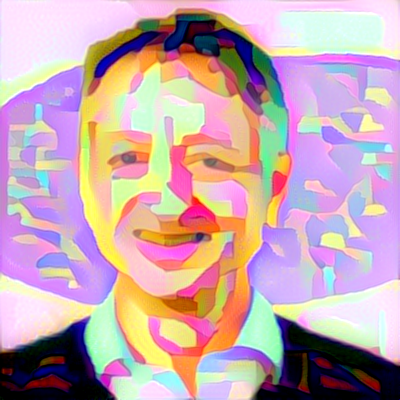

Train step: 4000
Image saved to /content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/content_block5_conv1_style_mixed.png


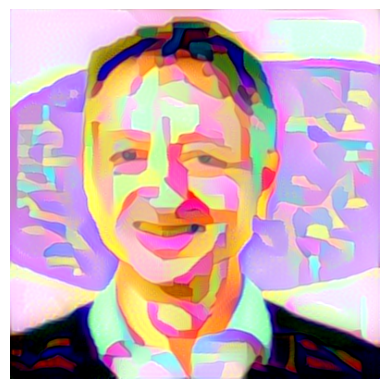

In [ ]:
cl = "block5_conv1"
sl = ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv4", "block5_conv4"]

iterations = 4000

# Reset generated image before each experiment
generated_image = tf.Variable(preprocess_image(base_image_path))

# Create a new optimizer for each set of weights
optimizer = keras.optimizers.RMSprop(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
        ),
        rho=0.9,
        epsilon=1e-7
    )

for i in range(1, iterations + 1):
   loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, cl, sl)
   optimizer.apply_gradients([(grads, generated_image)])
   print(".", end='', flush=True)
   if i % 100 == 0:
      print(f"Iteration {i}: loss={loss:.2f}")
      img = deprocess_image(generated_image.numpy())
      display.clear_output(wait=True)
      display.display(img)
      print("Train step: {}".format(i))

# Save the final image
img = deprocess_image(generated_image.numpy())
plt.imshow(img)
plt.axis('off')  # Hide axes

# Create a unique filename based on the weights
filename = f"content_{cl}_style_mixed.png"
save_path = f"/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/{filename}"
plt.imsave(save_path, img, cmap='gray')
print(f"Image saved to {save_path}")

This is interesting. It's not a better generated image, but it offers some interesting aspects that need to be further explored. The increased segmentation of the face offers hope that if we dig deeper into the style layer choice, it may get us closer to our desired results.

# Digging Deeper: Mixing Blocks during Style Loss

Because generating these imgages is very compute intensive, and takes a long time, let's not generate every combination of layers. Let's instead start by exploring a number of combinations, and see if it is then worth investigating further.

array([[[126, 215, 152],
        [130, 201, 148],
        [138, 201, 154],
        ...,
        [126, 216, 171],
        [121, 216, 167],
        [125, 212, 165]],

       [[123, 209, 153],
        [130, 193, 148],
        [145, 192, 154],
        ...,
        [130, 208, 171],
        [116, 211, 162],
        [115, 217, 150]],

       [[123, 210, 157],
        [134, 192, 150],
        [154, 187, 160],
        ...,
        [139, 197, 177],
        [120, 204, 164],
        [114, 216, 154]],

       ...,

       [[  0,   4, 100],
        [  0,   0,  81],
        [  0,   0,  73],
        ...,
        [  0,   4,  94],
        [  0,  13,  93],
        [  0,  16,  90]],

       [[  0,   8, 100],
        [  0,   0,  93],
        [  0,   0,  83],
        ...,
        [  0,  13, 107],
        [  0,  20, 108],
        [  0,  36, 123]],

       [[  0,   4,  94],
        [  0,   6,  96],
        [  0,   0,  89],
        ...,
        [  0,   0,  94],
        [  0,  13, 104],
        [  0,   0,  65]]], dtype=uint8)
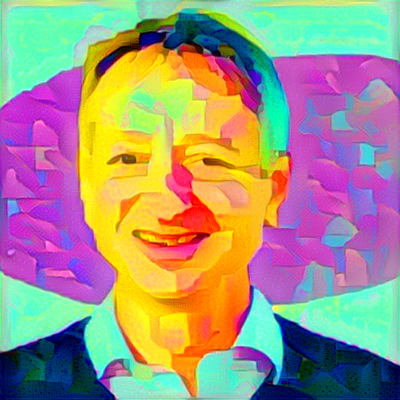

Train step: 4000
Image saved to /content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/content_block5_conv2_style_option_18.png


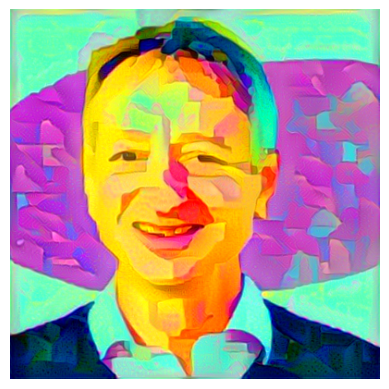

In [ ]:
cl = "block5_conv2"
style_layer_options = [
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv2", "block5_conv2"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv2", "block5_conv3"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv2", "block5_conv4"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv2"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv4"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv4", "block5_conv2"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv4", "block5_conv3"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv4", "block5_conv4"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv2", "block5_conv2"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv2", "block5_conv3"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv2", "block5_conv4"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv3", "block5_conv2"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv3", "block5_conv3"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv3", "block5_conv4"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv4", "block5_conv2"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv4", "block5_conv3"],
    ["block1_conv2", "block2_conv1", "block3_conv4", "block4_conv4", "block5_conv4"]
]

iterations = 4000

# If I include all layer details in the generated image filename, it will
# be impossible to work with. Instead, I will simply use a counter to
# distinguish the file names, and then cross reference back to the code to
# determine which counter corresponds to which settings.
counter = 0
for sl in style_layer_options:
    counter += 1
    # Reset generated image before each experiment
    generated_image = tf.Variable(preprocess_image(base_image_path))

    # Create a new optimizer for each set of weights
    optimizer = keras.optimizers.RMSprop(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
        ),
        rho=0.9,
        epsilon=1e-7
    )

    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, cl, sl)
        optimizer.apply_gradients([(grads, generated_image)])
        print(".", end='', flush=True)
        if i % 100 == 0:
            print(f"Iteration {i}: loss={loss:.2f}")
            img = deprocess_image(generated_image.numpy())
            display.clear_output(wait=True)
            display.display(img)
            print("Train step: {}".format(i))

    # Save the final image
    img = deprocess_image(generated_image.numpy())
    plt.imshow(img)
    plt.axis('off')  # Hide axes

    # Create a unique filename based on the weights
    filename = f"content_{cl}_style_option_{counter}.png"
    save_path = f"/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/{filename}"
    plt.imsave(save_path, img, cmap='gray')
    print(f"Image saved to {save_path}")

# *****************************************************************************
# To get this code to work on your system, you may need to re-write the
# save_path, depending on where you plan to write the generated images. As you
# can see, I chose to write them to the Experiments_Loss directory on my Google
# Drive. You may choose another approach or location.
# *****************************************************************************

It is clearly worth investigating further. You can either look at the generated images, or it is probably easier to look at the paper to see a summary of the results. It is becomming clear that layer choice is key to achieving our desired style in the generated image. As such, I'm going to dig a little deeper, and see some more combinations.

array([[[108, 225, 135],
        [109, 214, 132],
        [125, 219, 143],
        ...,
        [116, 224, 190],
        [115, 221, 179],
        [117, 224, 169]],

       [[105, 220, 134],
        [106, 203, 131],
        [127, 210, 146],
        ...,
        [119, 217, 189],
        [108, 214, 178],
        [113, 221, 165]],

       [[100, 222, 141],
        [110, 199, 139],
        [140, 194, 158],
        ...,
        [131, 208, 194],
        [112, 205, 183],
        [112, 216, 176]],

       ...,

       [[  0,   0,  65],
        [  0,   0,  63],
        [  0,   0,  67],
        ...,
        [  0,   0,  86],
        [  0,   0,  78],
        [  0,   0,  59]],

       [[  0,   0,  59],
        [  0,   0,  63],
        [  0,   0,  62],
        ...,
        [  0,   7, 100],
        [  0,  17,  91],
        [  0,  30,  97]],

       [[  0,   0,  57],
        [  0,   0,  62],
        [  0,   0,  54],
        ...,
        [  0,   0,  94],
        [  0,  14,  82],
        [  0,   0,  26]]], dtype=uint8)
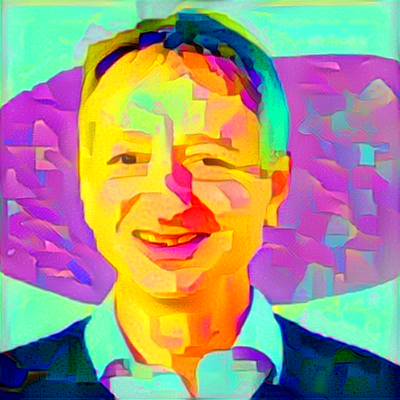

Train step: 4000
Image saved to /content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/content_block5_conv2_style_option_36.png


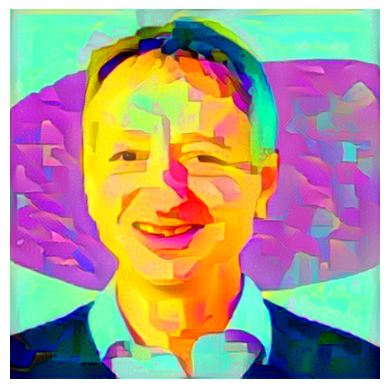

In [ ]:
cl = "block5_conv2"
style_layer_options = [
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv2", "block5_conv2"],
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv2", "block5_conv3"],
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv2", "block5_conv4"],
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv3", "block5_conv2"],
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv3", "block5_conv3"],
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv3", "block5_conv4"],
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv4", "block5_conv2"],
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv4", "block5_conv3"],
    ["block1_conv1", "block2_conv1", "block3_conv3", "block4_conv4", "block5_conv4"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv2", "block5_conv2"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv2", "block5_conv3"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv2", "block5_conv4"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv3", "block5_conv2"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv3", "block5_conv3"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv3", "block5_conv4"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4", "block5_conv2"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4", "block5_conv3"],
    ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4", "block5_conv4"]
]

iterations = 4000

# Note that this time I start the counter at the next number available after the
# previous code executed.
counter = 18
for sl in style_layer_options:
    counter += 1
    # Reset generated image before each experiment
    generated_image = tf.Variable(preprocess_image(base_image_path))

    # Create a new optimizer for each set of weights
    optimizer = keras.optimizers.RMSprop(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
        ),
        rho=0.9,
        epsilon=1e-7
    )

    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, cl, sl)
        optimizer.apply_gradients([(grads, generated_image)])
        print(".", end='', flush=True)
        if i % 100 == 0:
            print(f"Iteration {i}: loss={loss:.2f}")
            img = deprocess_image(generated_image.numpy())
            display.clear_output(wait=True)
            display.display(img)
            print("Train step: {}".format(i))

    # Save the final image
    img = deprocess_image(generated_image.numpy())
    plt.imshow(img)
    plt.axis('off')  # Hide axes

    # Create a unique filename based on the weights
    filename = f"content_{cl}_style_option_{counter}.png"
    save_path = f"/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/{filename}"
    plt.imsave(save_path, img, cmap='gray')
    print(f"Image saved to {save_path}")

# *****************************************************************************
# To get this code to work on your system, you may need to re-write the
# save_path, depending on where you plan to write the generated images. As you
# can see, I chose to write them to the Experiments_Loss directory on my Google
# Drive. You may choose another approach or location.
# *****************************************************************************

Okay, it is now becomming clear that:
- It is `block1_conv2` that is key to the generated images that have the faces containing more yellow coloring. Admittedly, this is subjective, but the generated images that use `block1_conv1` look better. Let’s focus on this block.
- The generated images that use `block2_conv2` clearly have cleaner lines and better segment definitions than those generated using `block2_conv1`. Let’s keep this additional definition, and choose `block2_conv2`.
- The generated images that use `block4_conv2` offer more detail in the chin and cheek areas of the face. Let’s keep this additional definition, and choose `block4_conv2`.
- It’s very minor, but `block5_conv3` and `block5_conv4` offer more clarity than `block5_conv2`. Let’s arbitrarily choose `block5_conv3`.

Okay, so we have settled on `block1_conv1`, `block2_conv2`, `block4_conv2`, and `block5_conv3`. But, thus far, all of these options have been generated using `block3_conv3`. Let's compare the other blocks...

array([[[249, 217, 255],
        [241, 205, 253],
        [249, 208, 255],
        ...,
        [173, 208, 157],
        [170, 207, 146],
        [171, 207, 140]],

       [[246, 215, 255],
        [238, 202, 255],
        [247, 206, 255],
        ...,
        [185, 221, 170],
        [176, 217, 157],
        [174, 217, 149]],

       [[245, 213, 255],
        [236, 202, 255],
        [244, 206, 255],
        ...,
        [194, 229, 184],
        [179, 224, 170],
        [173, 229, 166]],

       ...,

       [[  0,   0,  22],
        [  0,   0,  21],
        [  0,   0,  23],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,  26],
        [  0,   0,  31],
        [  0,   0,  32],
        ...,
        [  0,   1,   0],
        [  0,   0,   0],
        [  0,   0,   2]],

       [[  0,   0,  17],
        [  0,   0,  26],
        [  0,   0,  35],
        ...,
        [  0,   4,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
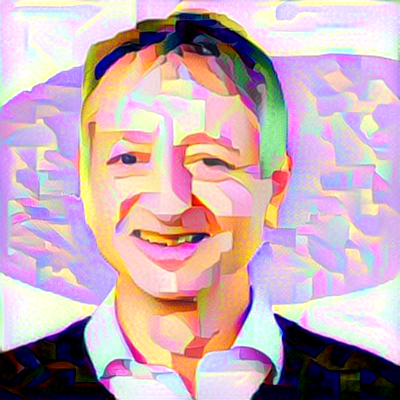

Train step: 4000
Image saved to /content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/content_block5_conv2_style_option_40.png


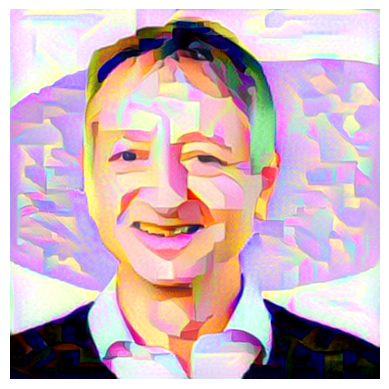

In [ ]:
cl = "block5_conv2"
style_layer_options = [
    ["block1_conv1", "block2_conv2", "block3_conv1", "block4_conv2", "block5_conv3"],
    ["block1_conv1", "block2_conv2", "block3_conv2", "block4_conv2", "block5_conv3"],
    ["block1_conv1", "block2_conv2", "block3_conv3", "block4_conv2", "block5_conv3"],
    ["block1_conv1", "block2_conv2", "block3_conv4", "block4_conv2", "block5_conv3"]
]

iterations = 4000

# Note that this time I start the counter at the next number available after the
# previous code executed.
counter = 36
for sl in style_layer_options:
    counter += 1
    # Reset generated image before each experiment
    generated_image = tf.Variable(preprocess_image(base_image_path))

    # Create a new optimizer for each set of weights
    optimizer = keras.optimizers.RMSprop(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
        ),
        rho=0.9,
        epsilon=1e-7
    )

    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, cl, sl)
        optimizer.apply_gradients([(grads, generated_image)])
        print(".", end='', flush=True)
        if i % 100 == 0:
            print(f"Iteration {i}: loss={loss:.2f}")
            img = deprocess_image(generated_image.numpy())
            display.clear_output(wait=True)
            display.display(img)
            print("Train step: {}".format(i))

    # Save the final image
    img = deprocess_image(generated_image.numpy())
    plt.imshow(img)
    plt.axis('off')  # Hide axes

    # Create a unique filename based on the weights
    filename = f"content_{cl}_style_option_{counter}.png"
    save_path = f"/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Layers/{filename}"
    plt.imsave(save_path, img, cmap='gray')
    print(f"Image saved to {save_path}")

# *****************************************************************************
# To get this code to work on your system, you may need to re-write the
# save_path, depending on where you plan to write the generated images. As you
# can see, I chose to write them to the Experiments_Loss directory on my Google
# Drive. You may choose another approach or location.
# *****************************************************************************